In [18]:
%matplotlib inline 
import numpy as np 
import os 
import math 
import openmc 

os.environ["PATH"] = "/storage/work/vai5027/.conda/envs/openmc-env1/bin:" + os.environ["PATH"]

os.environ["OPENMC_CROSS_SECTIONS"] = "/storage/home/vai5027/work/NUCE403/endfb-viii/cross_sections.xml"
## Defining materials


# This "fuel" is the classic UO2 and I added gadolinium as a burnable poison just to experiment (very sensitive to gad concentration). 
# I doubt that this is right so it will have to be revised. It should be a mix of UO2 and Gd2O3
fuel = openmc.Material(name='uo2_gad') 
fuel.add_nuclide('U235', 0.18) 
fuel.add_nuclide('U238', 0.82)
fuel.add_element('Gd', 0.0000)
fuel.add_nuclide('O16', 5) 
fuel.set_density('g/cm3', 11.5) 

cladding = openmc.Material(name='zircaloy4') 
cladding.add_element('Zr',0.98) 
cladding.add_element('Sn',0.015) 
cladding.add_element('Fe',0.002) 
cladding.add_element('Cr',0.001) 
cladding.add_element('O',0.001) 
cladding.add_element('Hf', 0.001) 
cladding.set_density('g/cm3', 6.34) 

water = openmc.Material(name='h2o') 
water.add_nuclide('H1', 2.0) 
water.add_nuclide('O16', 1.0) 
water.set_density('g/cm3', 1.0) 
water.add_s_alpha_beta('c_H_in_H2O')

ctrl_rod = openmc.Material(name='bc4')
ctrl_rod.add_nuclide('B10', 0.7)
ctrl_rod.add_nuclide('B11', 0.3)
ctrl_rod.add_nuclide('C12', 4)
ctrl_rod.set_density('g/cm3', 2.5)

rpv = openmc.Material(name='stainless_steel')   #Not really following any stablished "named" materials, just went with an approximation
rpv.add_element('Fe', 0.7)
rpv.add_element('Cr', 0.2)
rpv.add_element('Ni', 0.08)
rpv.add_element('Mn', 0.01)
rpv.add_element('C', 0.01)
rpv.set_density('g/cm3', 7.6)

mats = openmc.Materials([fuel, cladding, water, ctrl_rod, rpv]) 
mats.export_to_xml() 



## Defining geometry


# First defining dimensions and limiting surfaces for fuel, clad, and (when we had them) control rods
# Specify boundary conditions only to the exterior surfaces
# Changed the radius of the pellet to be more realistic (1 whole cm was a lot)

H_core = 225
R_core = 150
cyl_uo2 = openmc.ZCylinder(r=0.6)
cyl_clad = openmc.ZCylinder(r=0.62)
cyl_ctrl = openmc.ZCylinder(r=0.62)
cyl_no_ctrl = openmc.ZCylinder(r=0.62)
cyl_rpv_i = openmc.ZCylinder(r=R_core-10)
cyl_rpv_o = openmc.ZCylinder(r=R_core, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=H_core, boundary_type='vacuum')
z_min = openmc.ZPlane(z0=-H_core, boundary_type='vacuum')

# regions
uo2_region = -cyl_uo2 & -z_max & +z_min
clad_region = +cyl_uo2 & -cyl_clad & -z_max & +z_min
water_region = +cyl_clad & -z_max & +z_min
ctrl_region = -cyl_ctrl & -z_max & +z_min
no_ctrl_region = -cyl_no_ctrl & -z_max & +z_min
water_ctrl_region = +cyl_ctrl & -z_max & +z_min
water_no_ctrl_region = +cyl_no_ctrl & -z_max & +z_min
rpv_region = +cyl_rpv_i & -cyl_rpv_o & -z_max & +z_min
water_rod_region = -cyl_ctrl & -z_max & +z_min

# cells
uo2_cell = openmc.Cell(name='fuel')
uo2_cell.region = uo2_region
uo2_cell.fill = fuel

clad_cell = openmc.Cell(name='cladding')
clad_cell.region = clad_region
clad_cell.fill = cladding

ctrl_cell = openmc.Cell(name='ctrl_rod')
ctrl_cell.region = ctrl_region
ctrl_cell.fill = ctrl_rod

no_ctrl_cell = openmc.Cell(name='no_ctrl_rod')
no_ctrl_cell.region = no_ctrl_region
no_ctrl_cell.fill = water

water_cell = openmc.Cell(name='water')
water_cell.region = water_region
water_cell.fill = water

water_cell_ctrl = openmc.Cell(name='water_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_ctrl.region = water_ctrl_region
water_cell_ctrl.fill = water

water_cell_no_ctrl = openmc.Cell(name='water_no_ctrl')        # This might be unnecessary, essentially the same as the water cell
water_cell_no_ctrl.region = water_no_ctrl_region
water_cell_no_ctrl.fill = water

rpv_cell = openmc.Cell(name='vessel')
rpv_cell.region = rpv_region
rpv_cell.fill = rpv

water_rod_cell = openmc.Cell(name='water_rod_uncontrolled')
water_rod_cell.region = water_rod_region
water_rod_cell.fill = water

# universes, the outer universe i see it as a safety net so that everything is covered

fuel_universe = openmc.Universe(cells=[uo2_cell, clad_cell, water_cell])
ctrl_rod_universe = openmc.Universe(cells=[ctrl_cell, water_cell_ctrl])
outer_universe = openmc.Universe(cells=[openmc.Cell(fill=water)])
no_ctrl_rod_universe = openmc.Universe(cells=[no_ctrl_cell, water_cell_no_ctrl])

lat = openmc.HexLattice()    # this is the lattice of the fuel pins arranged into 3 rings to form the assembly
lat.center = (0., 0.)
lat.pitch = (4.6,)           # i picked this number just to make it fit, no calculations. 
# Changing this number affects k-eff a lot. Could make it smaller and even fit one more assembly ring
lat.outer = outer_universe

outer_ring = [fuel_universe] * 12
middle_ring = [fuel_universe] * 6
inner_ring = [no_ctrl_rod_universe]         # this used to be ctrl_rod_universe, but since we need burnable poisons it needs to be uncontrolled
lat.universes = [outer_ring, middle_ring, inner_ring] # this completely defines the lattice structure


# this defines the fuel assembly cell so that it can be stacked
a = 2.75 * lat.pitch[0]  # formula
outer_boundary = openmc.model.hexagonal_prism(edge_length=a, orientation='y')
main_cell = openmc.Cell(fill=lat, region=outer_boundary & -z_max & +z_min)

assembly_univ = openmc.Universe(cells=[main_cell]) #just "converting" the cell into a universe so that it can be merged

core_lat = openmc.HexLattice()
core_lat.center = (0.,0.)
core_lat.pitch = (np.sqrt(3)*a-0.8,)  # the sqrt3*a is the formula, then manually adjusting it so that it looks homogeneous
core_lat.outer = outer_universe # used the same outer as when defining the assemblies, it does not matter
core_lat.orientation = 'x' # these orientations are either x or y. I just change them until they agree lol

ring_1 = [assembly_univ]
ring_2 = [assembly_univ] * 6
ring_3 = [assembly_univ] * 12
ring_4 = [assembly_univ] * 18
ring_5 = [assembly_univ] * 24
ring_6 = [assembly_univ] * 30
ring_7 = [assembly_univ] * 36
core_lat.universes = [ring_7, ring_6, ring_5, ring_4, ring_3, ring_2, ring_1]

# only the "water" of the core, no pressure vessel
whole_core_cell = openmc.Cell(fill=core_lat, region=-cyl_rpv_i & -z_max & +z_min)

geom = openmc.Geometry([whole_core_cell, rpv_cell]) #pressure vessel added here
geom.export_to_xml()
"""
p = openmc.Plot() 
p.basis = 'xy'       
p.origin = (0, 0, 0) 
p.width = (305, 305)   
p.color_by = 'material'
p.colors = {water: 'blue',fuel: 'black',cladding: 'red',ctrl_rod: 'gray', rpv: 'purple'}

p.path_to_geometry = geom.export_to_xml()

p.to_ipython_image()
"""

"\np = openmc.Plot() \np.basis = 'xy'       \np.origin = (0, 0, 0) \np.width = (305, 305)   \np.color_by = 'material'\np.colors = {water: 'blue',fuel: 'black',cladding: 'red',ctrl_rod: 'gray', rpv: 'purple'}\n\np.path_to_geometry = geom.export_to_xml()\n\np.to_ipython_image()\n"

In [19]:
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
settings.run_mode = 'eigenvalue'
settings.export_to_xml()

In [20]:
 # Depletion Cell
import openmc.deplete
fuel.volume = np.pi * (cyl_uo2.r**2) * H_core * 2286
chain = openmc.deplete.Chain.from_xml("./chain_simple.xml")
model = openmc.Model(geometry=geom, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "./chain_simple.xml")
power = 20e6 # W
time_steps = [0.1,0.2,0.4,0.8,1.6,2.5,5,10,20,40,80,100] # Days
cecm = openmc.deplete.CECMIntegrator(operator, time_steps, power, timestep_units='d') # also better options available
cecm.integrate(4)




                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading C13 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/C13.h5
 Reading Mn55 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Mn55.h5
 Reading Ni58 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni58.h5
 Reading Ni60 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni60.h5
 Reading Ni61 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni61.h5
 Reading Ni62 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni62.h5
 Reading Ni64 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ni64.h5
 Reading c_H_in_H2O from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=8640.0 s, source=20000000.0
 Reading Ba135 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ba135.h5


 Reading Ba136 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ba136.h5
 Reading Ba138 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ba138.h5
 Reading I134 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/I134.h5
 Reading I135 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/I135.h5
 Reading Xe135 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Xe135.h5
 Reading Xe134 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Xe134.h5
 Reading Xe136 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Xe136.h5
 Reading Cs135 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Cs135.h5
 Reading Cs136 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Cs136.h5


          1200K
          2500K


 Reading Cs137 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Cs137.h5
 Reading Ba137 from
 /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/Ba137.h5
 Reading U234 from /storage/home/vai5027/work/NUCE403/endfb-viii/neutron/U234.h5
 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.19249
        2/1    1.18600
        3/1    1.19787
        4/1    1.17493
        5/1    1.25115
        6/1    1.19165
        7/1    1.14091
        8/1    1.26980
        9/1    1.16683
       10/1    1.11496
       11/1    1.29103
       12/1    1.13404    1.21253 +/- 0.07849
       13/1    1.10608    1.17705 +/- 0.05756
       14/1    1.05588    1.14676 +/- 0.05074
       15/1    1.13320    1.14404 +/- 0.03939
       16/1    1.18894    1.15153 +/- 0.03302
       17/1 

       45/1    1.17692    1.19774 +/- 0.00840
       46/1    1.22805    1.19859 +/- 0.00820
       47/1    1.21791    1.19911 +/- 0.00800
       48/1    1.18977    1.19886 +/- 0.00779
       49/1    1.10029    1.19633 +/- 0.00799
       50/1    1.18469    1.19604 +/- 0.00780
       51/1    1.19590    1.19604 +/- 0.00760
       52/1    1.17011    1.19542 +/- 0.00745
       53/1    1.12131    1.19370 +/- 0.00747
       54/1    1.13565    1.19238 +/- 0.00742
       55/1    1.15735    1.19160 +/- 0.00729
       56/1    1.09393    1.18948 +/- 0.00744
       57/1    1.20519    1.18981 +/- 0.00729
       58/1    1.12013    1.18836 +/- 0.00728
       59/1    1.19594    1.18852 +/- 0.00713
       60/1    1.19027    1.18855 +/- 0.00699
       61/1    1.19102    1.18860 +/- 0.00685
       62/1    1.15902    1.18803 +/- 0.00674
       63/1    1.17322    1.18775 +/- 0.00662
       64/1    1.20259    1.18803 +/- 0.00650
       65/1    1.15202    1.18737 +/- 0.00642
       66/1    1.10222    1.18585 

       96/1    1.18239    1.17790 +/- 0.00625
       97/1    1.05327    1.17647 +/- 0.00634
       98/1    1.20954    1.17685 +/- 0.00628
       99/1    1.13708    1.17640 +/- 0.00623
      100/1    1.13757    1.17597 +/- 0.00617
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 7.9174e+00 seconds
   Time in transport only          = 7.7993e+00 seconds
   Time in inactive batches        = 6.7874e-01 seconds
   Time in active batches          = 7.2387e+00 seconds
   Time synchronizing fission bank = 4.8872e-03 seconds
     Sampling source sites         = 3.9901e-03 seconds
     SEND/RECV source sites        = 7.0180e-04 seconds
   Time accumulating tallies       = 2.1782e-04 seconds
   Time writing statepoints        = 1.0040e-01 seconds
 Total time for finalization    

       15/1    1.17292    1.17401 +/- 0.01493
       16/1    1.23432    1.18406 +/- 0.01580
       17/1    1.18679    1.18445 +/- 0.01336
       18/1    1.21974    1.18886 +/- 0.01238
       19/1    1.21450    1.19171 +/- 0.01129
       20/1    1.20605    1.19315 +/- 0.01020
       21/1    1.10808    1.18541 +/- 0.01204
       22/1    1.12530    1.18040 +/- 0.01207
       23/1    1.12352    1.17603 +/- 0.01194
       24/1    1.14385    1.17373 +/- 0.01129
       25/1    1.12138    1.17024 +/- 0.01107
       26/1    1.22016    1.17336 +/- 0.01082
       27/1    1.29126    1.18029 +/- 0.01230
       28/1    1.20164    1.18148 +/- 0.01166
       29/1    1.17902    1.18135 +/- 0.01103
       30/1    1.17129    1.18085 +/- 0.01048
       31/1    1.19435    1.18149 +/- 0.00999
       32/1    1.18798    1.18179 +/- 0.00953
       33/1    1.16468    1.18104 +/- 0.00913
       34/1    1.20517    1.18205 +/- 0.00880
       35/1    1.24008    1.18437 +/- 0.00875
       36/1    1.22343    1.18587 

       66/1    1.05451    1.17865 +/- 0.00823
       67/1    1.24132    1.17975 +/- 0.00816
       68/1    1.16050    1.17942 +/- 0.00802
       69/1    1.17547    1.17935 +/- 0.00788
       70/1    1.15376    1.17893 +/- 0.00776
       71/1    1.19437    1.17918 +/- 0.00764
       72/1    1.16564    1.17896 +/- 0.00752
       73/1    1.29564    1.18081 +/- 0.00763
       74/1    1.19155    1.18098 +/- 0.00751
       75/1    1.19376    1.18118 +/- 0.00739
       76/1    1.25096    1.18224 +/- 0.00736
       77/1    1.17246    1.18209 +/- 0.00725
       78/1    1.11606    1.18112 +/- 0.00721
       79/1    1.19005    1.18125 +/- 0.00710
       80/1    1.15252    1.18084 +/- 0.00701
       81/1    1.19588    1.18105 +/- 0.00692
       82/1    1.15978    1.18075 +/- 0.00683
       83/1    1.20328    1.18106 +/- 0.00674
       84/1    1.10364    1.18002 +/- 0.00673
       85/1    1.12355    1.17926 +/- 0.00668
       86/1    1.18269    1.17931 +/- 0.00659
       87/1    1.19030    1.17945 

 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.15664
        2/1    1.15081
        3/1    1.20429
        4/1    1.21297
        5/1    1.16530
        6/1    1.15992
        7/1    1.08785
        8/1    1.21465
        9/1    1.08793
       10/1    1.24828
       11/1    1.18212
       12/1    1.22334    1.20273 +/- 0.02061
       13/1    1.22040    1.20862 +/- 0.01328
       14/1    1.18122    1.20177 +/- 0.01162
       15/1    1.31317    1.22405 +/- 0.02403
       16/1    1.25082    1.22851 +/- 0.02012
       17/1    1.18838    1.22278 +/- 0.01795
       18/1    1.17123    1.21633 +/- 0.01682
       19/1    1.19440    1.21390 +/- 0.01504
       20/1    1.20784    1.21329 +/- 0.01346
       21/1    1.20614    1.21264 +/- 0.01219
       22/1    1.19583    1.211

       51/1    1.12478    1.16770 +/- 0.00857
       52/1    1.15976    1.16751 +/- 0.00837
       53/1    1.22431    1.16883 +/- 0.00828
       54/1    1.12246    1.16778 +/- 0.00816
       55/1    1.15734    1.16754 +/- 0.00798
       56/1    1.13702    1.16688 +/- 0.00783
       57/1    1.12462    1.16598 +/- 0.00771
       58/1    1.21404    1.16698 +/- 0.00762
       59/1    1.19975    1.16765 +/- 0.00749
       60/1    1.21888    1.16868 +/- 0.00741
       61/1    1.20080    1.16931 +/- 0.00729
       62/1    1.27821    1.17140 +/- 0.00745
       63/1    1.24089    1.17271 +/- 0.00742
       64/1    1.27310    1.17457 +/- 0.00752
       65/1    1.15450    1.17421 +/- 0.00739
       66/1    1.05049    1.17200 +/- 0.00759
       67/1    1.18368    1.17220 +/- 0.00745
       68/1    1.06849    1.17041 +/- 0.00754
       69/1    1.17362    1.17047 +/- 0.00741
       70/1    1.13082    1.16981 +/- 0.00732
       71/1    1.09500    1.16858 +/- 0.00730
       72/1    1.16845    1.16858 

[openmc.deplete] t=267840.0 s, dt=216000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.14537
        2/1    1.20748
        3/1    1.11560
        4/1    1.22133
        5/1    1.17428
        6/1    1.21099
        7/1    1.23169
        8/1    1.19987
        9/1    1.28900
       10/1    1.19291
       11/1    1.22635
       12/1    1.22822    1.22728 +/- 0.00094
       13/1    1.08694    1.18050 +/- 0.04679
       14/1    1.15954    1.17526 +/- 0.03349
       15/1    1.16234    1.17268 +/- 0.02607
       16/1    1.15536    1.16979 +/- 0.02148
       17/1    1.21934    1.17687 +/- 0.01949
       18/1    1.13405    1.17152 +/- 0.01771
       19/1    1.23885    1.17900 +/- 0.01731
       20/1    1.20547    1.18165 +/- 0.01571
       21/1  

       51/1    1.18984    1.17575 +/- 0.00848
       52/1    1.19019    1.17609 +/- 0.00828
       53/1    1.12614    1.17493 +/- 0.00817
       54/1    1.16896    1.17480 +/- 0.00798
       55/1    1.09982    1.17313 +/- 0.00798
       56/1    1.21786    1.17410 +/- 0.00786
       57/1    1.15125    1.17362 +/- 0.00771
       58/1    1.22242    1.17463 +/- 0.00761
       59/1    1.21306    1.17542 +/- 0.00750
       60/1    1.10737    1.17406 +/- 0.00747
       61/1    1.31539    1.17683 +/- 0.00783
       62/1    1.18615    1.17701 +/- 0.00768
       63/1    1.23908    1.17818 +/- 0.00762
       64/1    1.29844    1.18041 +/- 0.00781
       65/1    1.14714    1.17980 +/- 0.00769
       66/1    1.18173    1.17984 +/- 0.00755
       67/1    1.16321    1.17954 +/- 0.00742
       68/1    1.17760    1.17951 +/- 0.00729
       69/1    1.22028    1.18020 +/- 0.00720
       70/1    1.16791    1.18000 +/- 0.00708
       71/1    1.13509    1.17926 +/- 0.00700
       72/1    1.17214    1.17915 

 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.21120
        2/1    1.25547
        3/1    1.16255
        4/1    1.23792
        5/1    1.25776
        6/1    1.15825
        7/1    1.19286
        8/1    1.13206
        9/1    1.20130
       10/1    1.16364
       11/1    1.18064
       12/1    1.08045    1.13054 +/- 0.05009
       13/1    1.15016    1.13708 +/- 0.02965
       14/1    1.20638    1.15441 +/- 0.02720
       15/1    1.24073    1.17167 +/- 0.02724
       16/1    1.06937    1.15462 +/- 0.02802
       17/1    1.12674    1.15064 +/- 0.02402
       18/1    1.24290    1.16217 +/- 0.02378
       19/1    1.20710    1.16716 +/- 0.02156
       20/1    1.15044    1.16549 +/- 0.01936
       21/1    1.23373    1.17169 +/- 0.01858
       22/1    1.12257    1.167

       51/1    1.15000    1.19268 +/- 0.00900
       52/1    1.08817    1.19019 +/- 0.00913
       53/1    1.12057    1.18857 +/- 0.00906
       54/1    1.27509    1.19054 +/- 0.00907
       55/1    1.20473    1.19085 +/- 0.00887
       56/1    1.23814    1.19188 +/- 0.00873
       57/1    1.21670    1.19241 +/- 0.00856
       58/1    1.23285    1.19325 +/- 0.00842
       59/1    1.12092    1.19178 +/- 0.00838
       60/1    1.11735    1.19029 +/- 0.00835
       61/1    1.22398    1.19095 +/- 0.00821
       62/1    1.12289    1.18964 +/- 0.00815
       63/1    1.07486    1.18747 +/- 0.00829
       64/1    1.18187    1.18737 +/- 0.00813
       65/1    1.11334    1.18603 +/- 0.00810
       66/1    1.26328    1.18740 +/- 0.00807
       67/1    1.15609    1.18686 +/- 0.00794
       68/1    1.20717    1.18721 +/- 0.00781
       69/1    1.12340    1.18612 +/- 0.00776
       70/1    1.13059    1.18520 +/- 0.00768
       71/1    1.11469    1.18404 +/- 0.00764
       72/1    1.20859    1.18444 

[openmc.deplete] t=1779840.0 s, dt=1728000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.17620
        2/1    1.17677
        3/1    1.17133
        4/1    1.23078
        5/1    1.19952
        6/1    1.20617
        7/1    1.21735
        8/1    1.12714
        9/1    1.19181
       10/1    1.22374
       11/1    1.22537
       12/1    1.20858    1.21697 +/- 0.00839
       13/1    1.21078    1.21491 +/- 0.00527
       14/1    1.18954    1.20857 +/- 0.00735
       15/1    1.20648    1.20815 +/- 0.00571
       16/1    1.12219    1.19382 +/- 0.01507
       17/1    1.19971    1.19466 +/- 0.01276
       18/1    1.27899    1.20520 +/- 0.01527
       19/1    1.06935    1.19011 +/- 0.02023
       20/1    1.16815    1.18791 +/- 0.01823
       21/1

       51/1    1.16842    1.17681 +/- 0.00762
       52/1    1.17630    1.17680 +/- 0.00744
       53/1    1.25065    1.17852 +/- 0.00746
       54/1    1.19408    1.17887 +/- 0.00730
       55/1    1.26883    1.18087 +/- 0.00741
       56/1    1.35405    1.18464 +/- 0.00817
       57/1    1.14270    1.18374 +/- 0.00804
       58/1    1.25198    1.18516 +/- 0.00800
       59/1    1.11516    1.18374 +/- 0.00796
       60/1    1.16578    1.18338 +/- 0.00781
       61/1    1.16418    1.18300 +/- 0.00767
       62/1    1.26071    1.18449 +/- 0.00766
       63/1    1.28371    1.18637 +/- 0.00775
       64/1    1.11544    1.18505 +/- 0.00772
       65/1    1.15205    1.18445 +/- 0.00760
       66/1    1.12500    1.18339 +/- 0.00754
       67/1    1.16813    1.18312 +/- 0.00741
       68/1    1.13211    1.18224 +/- 0.00733
       69/1    1.13399    1.18143 +/- 0.00725
       70/1    1.16590    1.18117 +/- 0.00714
       71/1    1.08975    1.17967 +/- 0.00718
       72/1    1.20824    1.18013 

 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.19252
        2/1    1.15697
        3/1    1.21157
        4/1    1.19466
        5/1    1.11145
        6/1    1.24842
        7/1    1.21712
        8/1    1.20964
        9/1    1.15781
       10/1    1.16438
       11/1    1.16092
       12/1    1.20683    1.18387 +/- 0.02296
       13/1    1.17474    1.18083 +/- 0.01360
       14/1    1.22588    1.19209 +/- 0.01481
       15/1    1.09080    1.17183 +/- 0.02328
       16/1    1.25234    1.18525 +/- 0.02327
       17/1    1.22448    1.19086 +/- 0.02045
       18/1    1.27951    1.20194 +/- 0.02089
       19/1    1.22193    1.20416 +/- 0.01856
       20/1    1.22146    1.20589 +/- 0.01669
       21/1    1.06968    1.19351 +/- 0.01952
       22/1    1.22942    1.196

       51/1    1.15328    1.18066 +/- 0.00867
       52/1    1.19333    1.18096 +/- 0.00847
       53/1    1.20938    1.18162 +/- 0.00830
       54/1    1.17383    1.18144 +/- 0.00811
       55/1    1.16100    1.18099 +/- 0.00794
       56/1    1.28058    1.18315 +/- 0.00806
       57/1    1.17774    1.18304 +/- 0.00789
       58/1    1.07143    1.18071 +/- 0.00806
       59/1    1.14816    1.18005 +/- 0.00793
       60/1    1.21514    1.18075 +/- 0.00780
       61/1    1.19212    1.18097 +/- 0.00765
       62/1    1.17910    1.18094 +/- 0.00750
       63/1    1.19963    1.18129 +/- 0.00736
       64/1    1.22070    1.18202 +/- 0.00726
       65/1    1.14411    1.18133 +/- 0.00716
       66/1    1.17955    1.18130 +/- 0.00703
       67/1    1.11095    1.18006 +/- 0.00702
       68/1    1.24228    1.18114 +/- 0.00698
       69/1    1.17650    1.18106 +/- 0.00686
       70/1    1.11791    1.18001 +/- 0.00683
       71/1    1.11600    1.17896 +/- 0.00680
       72/1    1.19362    1.17919 

[openmc.deplete] t=13875840.0 s, dt=8640000.0 s, source=20000000.0
 Maximum neutron transport energy: 20000000 eV for Gd157
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.17431
        2/1    1.18741
        3/1    1.16295
        4/1    1.20785
        5/1    1.29848
        6/1    1.16743
        7/1    1.15211
        8/1    1.25302
        9/1    1.30306
       10/1    1.18923
       11/1    1.13676
       12/1    1.20775    1.17226 +/- 0.03550
       13/1    1.24324    1.19592 +/- 0.03130
       14/1    1.25078    1.20964 +/- 0.02604
       15/1    1.17432    1.20257 +/- 0.02137
       16/1    1.21564    1.20475 +/- 0.01759
       17/1    1.23981    1.20976 +/- 0.01568
       18/1    1.18235    1.20633 +/- 0.01401
       19/1    1.23857    1.20991 +/- 0.01286
       20/1    1.24897    1.21382 +/- 0.01215
       21/

       51/1    1.18694    1.17532 +/- 0.00751
       52/1    1.18351    1.17552 +/- 0.00733
       53/1    1.12621    1.17437 +/- 0.00725
       54/1    1.24846    1.17605 +/- 0.00728
       55/1    1.21921    1.17701 +/- 0.00718
       56/1    1.13146    1.17602 +/- 0.00710
       57/1    1.12993    1.17504 +/- 0.00701
       58/1    1.15242    1.17457 +/- 0.00688
       59/1    1.09272    1.17290 +/- 0.00694
       60/1    1.11061    1.17166 +/- 0.00692
       61/1    1.23023    1.17280 +/- 0.00688
       62/1    1.15391    1.17244 +/- 0.00675
       63/1    1.13084    1.17166 +/- 0.00667
       64/1    1.18049    1.17182 +/- 0.00655
       65/1    1.15344    1.17148 +/- 0.00644
       66/1    1.08108    1.16987 +/- 0.00652
       67/1    1.10688    1.16877 +/- 0.00650
       68/1    1.18690    1.16908 +/- 0.00640
       69/1    1.09427    1.16781 +/- 0.00641
       70/1    1.13646    1.16729 +/- 0.00633
       71/1    1.16744    1.16729 +/- 0.00622
       72/1    1.20113    1.16784 


 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 8.1778e+00 seconds
   Time in transport only          = 7.8591e+00 seconds
   Time in inactive batches        = 6.9351e-01 seconds
   Time in active batches          = 7.4843e+00 seconds
   Time synchronizing fission bank = 4.8851e-03 seconds
     Sampling source sites         = 3.9934e-03 seconds
     SEND/RECV source sites        = 6.9415e-04 seconds
   Time accumulating tallies       = 2.1978e-04 seconds
   Time writing statepoints        = 3.0104e-01 seconds
 Total time for finalization       = 5.3938e-03 seconds
 Total time elapsed                = 8.2373e+00 seconds
 Calculation Rate (inactive)       = 14419.5 particles/second
 Calculation Rate (active)         = 12025.1 particles/second

 ============================>     RESULTS     <====================

In [21]:
# Checking to see how many files were created

!ls *.h5


depletion_results.h5	  openmc_simulation_n17.h5  openmc_simulation_n3.h5
openmc_simulation_n0.h5   openmc_simulation_n18.h5  openmc_simulation_n4.h5
openmc_simulation_n1.h5   openmc_simulation_n19.h5  openmc_simulation_n5.h5
openmc_simulation_n10.h5  openmc_simulation_n2.h5   openmc_simulation_n6.h5
openmc_simulation_n11.h5  openmc_simulation_n20.h5  openmc_simulation_n7.h5
openmc_simulation_n12.h5  openmc_simulation_n21.h5  openmc_simulation_n8.h5
openmc_simulation_n13.h5  openmc_simulation_n22.h5  openmc_simulation_n9.h5
openmc_simulation_n14.h5  openmc_simulation_n23.h5  statepoint.100.h5
openmc_simulation_n15.h5  openmc_simulation_n24.h5  summary.h5
openmc_simulation_n16.h5  openmc_simulation_n25.h5


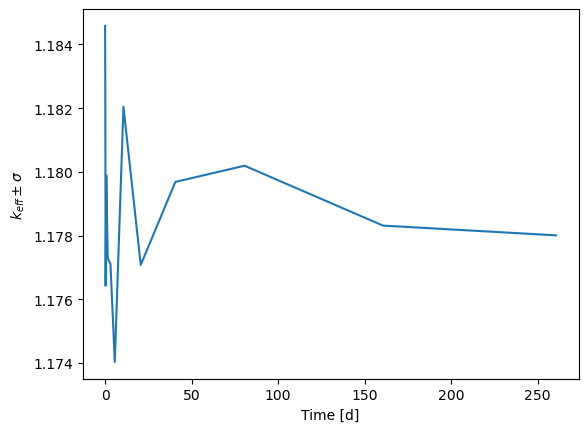

In [28]:
# Depletetion Post Processing 

results = openmc.deplete.Results("./depletion_results.h5")
time, k = results.get_keff()
time /= (24 * 60 * 60)  # convert back to days from seconds
from matplotlib import pyplot
pyplot.plot(time, k[:, 0])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");
